# Convolutional Neural Networks with 8 layersでのSmoothgrad
# On MNIST
# Adding Noise when  training and testing

# Reference https://github.com/experiencor/deep-viz-keras

In [1]:
from keras.preprocessing import image
import numpy as np

from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
import PIL.Image
import keras.backend as K
from matplotlib import pylab as plt

%matplotlib inline

Using TensorFlow backend.


In [7]:
from keras import layers
from keras import models
from keras.layers.noise import GaussianNoise
model = models.Sequential()
model.add(GaussianNoise(.2, input_shape=(28, 28, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)               0         
__________

In [9]:
from keras.datasets import mnist
from keras.utils import to_categorical
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [10]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 78s - loss: 0.2058 - acc: 0.9352    
Epoch 2/5
60000/60000 [==============================] - 78s - loss: 0.0577 - acc: 0.9819    
Epoch 3/5
60000/60000 [==============================] - 82s - loss: 0.0440 - acc: 0.9868    
Epoch 4/5
60000/60000 [==============================] - 79s - loss: 0.0349 - acc: 0.9890    
Epoch 5/5
60000/60000 [==============================] - 81s - loss: 0.0303 - acc: 0.9902    


In [11]:
model.save('mnist_noise.h5')

In [12]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

 9952/10000 [============================>.] - ETA: 0s

0.99199999999999999

In [13]:
test_images[0].shape

(28, 28, 1)

# 最初のテスト画像：７にSmoothgradを行う

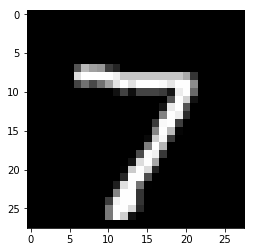

In [14]:
img = test_images[0].reshape(28, 28)
plt.imshow(img, cmap='gray')

In [15]:
x = np.expand_dims(test_images[0], axis=0)
preds = model.predict(x)
label = np.argmax(preds)
print("Predicted labels is: {0} ".format(label))
print(np.sort(preds)[0][-1])

Predicted labels is: 7 
1.0


In [16]:
cd ../../../deep-viz-keras/

/Users/kentasuzuki/deep-viz-keras


In [17]:
ls

Examples.ipynb              integrated_gradients_ks.py
README.md                   saliency.pyc
__pycache__/                saliency_ks.py
guided_backprop.pyc         utils.py
guided_backprop_ks.py       visual_backprop.pyc
images/                     visual_backprop_ks.py
integrated_gradients.pyc


In [18]:
print(x.shape)
print(x[0].shape)

(1, 28, 28, 1)
(28, 28, 1)


In [19]:
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)
    
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

In [20]:
x2 = x.reshape(28, 28, 1)

# Comparison:  Vanila gradient VS SmoothGrad

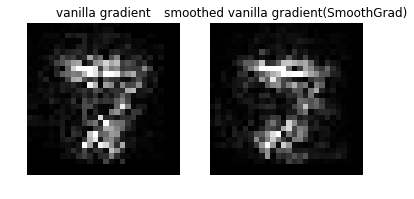

In [21]:
from saliency_ks import GradientSaliency
vanilla = GradientSaliency(model)

mask = vanilla.get_mask(x[0])
show_image(mask, ax=plt.subplot('121'), title='vanilla gradient')

mask = vanilla.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot('122'), title='smoothed vanilla gradient(SmoothGrad)')

# Comparison: GuidedBackprop gradient VS SmoothGrad+Backprop

In [22]:
from guided_backprop_ks import GuidedBackprop
guided_bprop = GuidedBackprop(model)

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


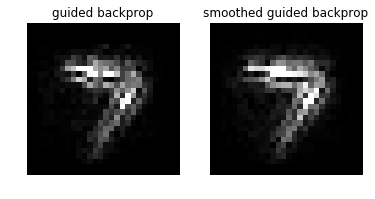

In [23]:
mask = guided_bprop.get_mask(x[0])
show_image(mask, ax=plt.subplot('121'), title='guided backprop')

mask = guided_bprop.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot('122'), title='smoothed guided backprop')

# Comparison: Integrated gradient VS SmoothGrad+Integrated grad

In [24]:
from integrated_gradients_ks import IntegratedGradients
inter_grad = IntegratedGradients(model)

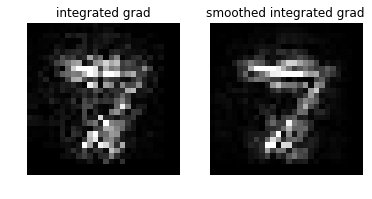

In [25]:
mask = inter_grad.get_mask(x[0])
show_image(mask, ax=plt.subplot('121'), title='integrated grad')

mask = inter_grad.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot('122'), title='smoothed integrated grad')

In [26]:
from visual_backprop_ks import VisualBackprop
visual_bprop = VisualBackprop(model)

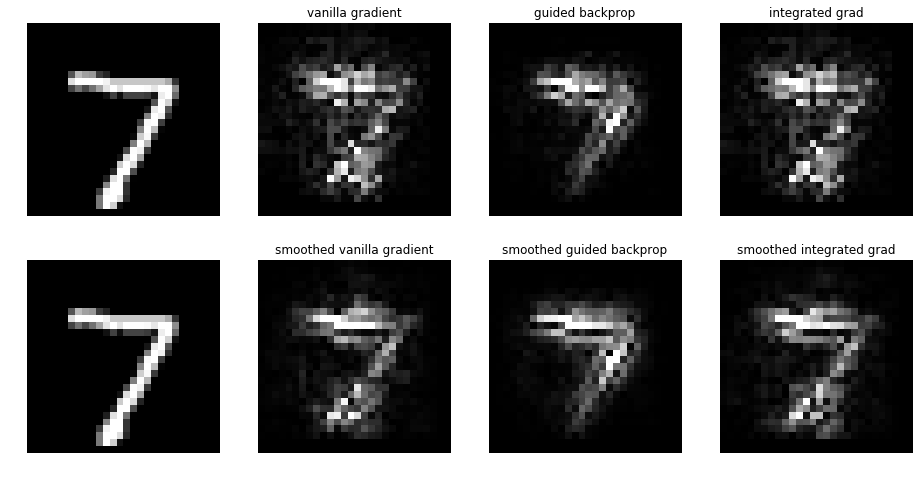

In [27]:
plt.figure(figsize=(20,8))

# Plot non-smoothed versions
show_image(img, grayscale=False, ax=plt.subplot(251))

mask = vanilla.get_mask(x[0])
show_image(mask, ax=plt.subplot(252), title='vanilla gradient')

mask = guided_bprop.get_mask(x[0])
show_image(mask, ax=plt.subplot(253), title='guided backprop')

mask = inter_grad.get_mask(x[0])
show_image(mask, ax=plt.subplot(254), title='integrated grad')



# Plot smoothed versions
show_image(img, grayscale=False, ax=plt.subplot(256))

mask = vanilla.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot(257), title='smoothed vanilla gradient')

mask = guided_bprop.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot(258), title='smoothed guided backprop')

mask = inter_grad.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot(259), title='smoothed integrated grad')


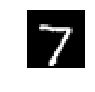

In [28]:
# Plot non-smoothed versions
show_image(img, grayscale=False, ax=plt.subplot(251))

# Noise level(standard deviation)を0％から50％に変える　　　　#　画像から10%が適切（原型を保持している）

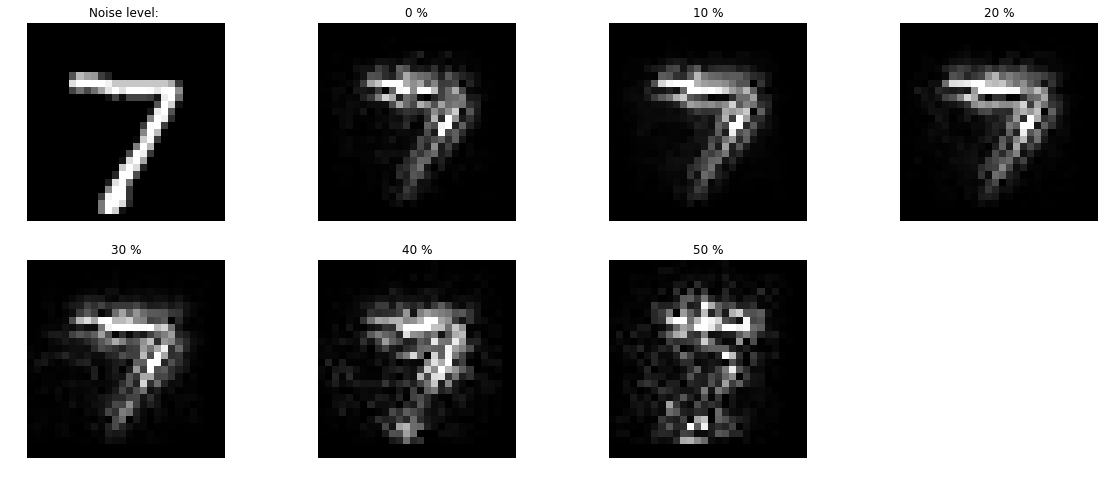

In [29]:
plt.figure(figsize=(20,8))
for noise in range(-1, 6):
    if noise == -1:
        # Plot non-smoothed versions
        show_image(img, grayscale=False, ax=plt.subplot(241), title="Noise level: ")
    else:
        mask = guided_bprop.get_smoothed_mask(x[0], stdev_spread=noise/10)
        show_image(mask, ax=plt.subplot(242 + noise), title='{0} %'.format(noise*10))

# Sample size(N) を変える（noise level := 10%）
# N = 20,50,100 seems appropriate

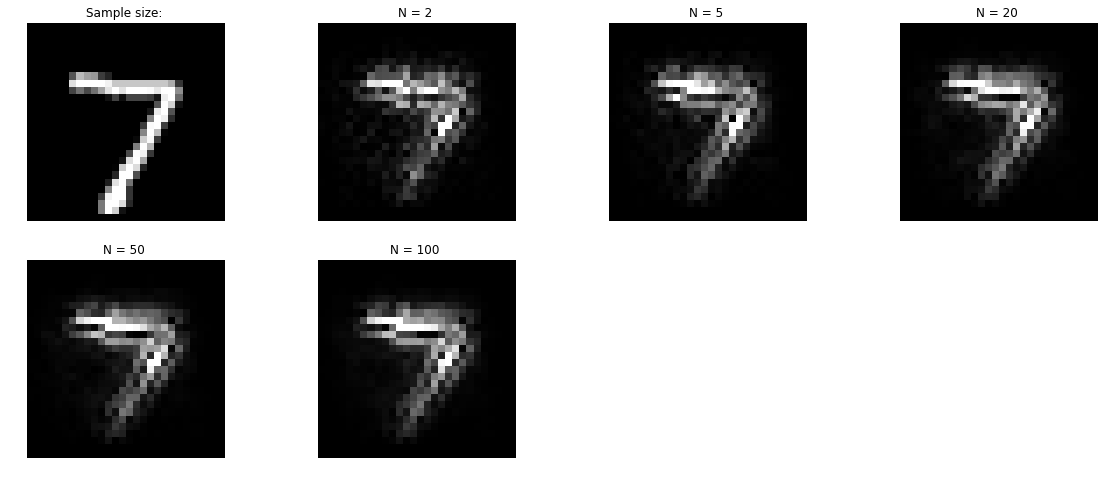

In [30]:
samples = [2,5,20,50,100]
plt.figure(figsize=(20,8))
for i, noise in enumerate(range(-1, 6)):
    if noise == -1:
        # Plot non-smoothed versions
        show_image(img, grayscale=False, ax=plt.subplot(241), title="Sample size: ")
    else:
        if i == 6:
            break
        sample = samples[i-1]
        mask = guided_bprop.get_smoothed_mask(x[0], stdev_spread=0.1, nsamples=sample)
        show_image(mask, ax=plt.subplot(242 + noise), title='N = {0} '.format(sample))